In [1]:
import sys
import warnings

if not sys.warnoptions:
    warnings.simplefilter('ignore')

In [2]:
import tensorflow as tf

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime
from datetime import timedelta
from tqdm import tqdm
from GRU_stock_data_processing import *
# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

sns.set()
tf.random.set_seed(1234)

### Load Numerical Dataset and Select Ticker

In [134]:
stock_df = pd.read_csv("../stock_yfinance_data.csv")
ticker = 'TSLA'
stock_filt = stock_df['Stock Name'] == ticker
df = stock_df[stock_filt]
window = 30
df = clean_stock_data(df, window)
df.head()

,date,open,high,low,close,adj_close,volume,stock_name,moving_max,moving_min,moving_avg_volume,moving_avg_HL
0,2021-09-30,260.333344,263.043335,258.333344,258.493347,258.493347,53868000,TSLA,258.493347,258.493347,53868000.0,4.709991
1,2021-10-01,259.466675,260.260010,254.529999,258.406677,258.406677,51094200,TSLA,258.493347,258.406677,52481100.0,5.220001
2,2021-10-04,265.500000,268.989990,258.706665,260.510010,260.510010,91449900,TSLA,260.510010,258.406677,65470700.0,6.907776
3,2021-10-05,261.600006,265.769989,258.066681,260.196655,260.196655,55297800,TSLA,260.510010,258.406677,62927475.0,7.106659
4,2021-10-06,258.733337,262.220001,257.739990,260.916656,260.916656,43898400,TSLA,260.916656,258.406677,59121660.0,6.581329


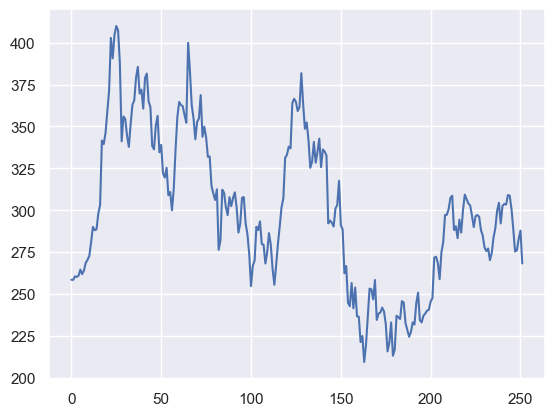

In [135]:
plt.plot(df['close'].values)

### Generate Useful Numerical Features

In [8]:
features = gen_features(df)
#only keep window-end samples before full window are invalid
features = features[window:]
features.head()

,target,close,volume,day_HL,sma,ema,rsi,macd_line,macd_signal,macd_histogram,bb_middle,bb_upper,bb_lower
30,-0.415753,1.389737,-0.225144,1.205485,1.225250,1.240823,1.294347,0.337084,0.377391,-0.040307,1.225250,2.329673,0.120826
31,-2.829310,1.274551,-0.123877,0.834094,1.271798,1.244036,1.048356,0.298930,0.361699,-0.062768,1.271798,2.295270,0.248325
32,-1.938224,1.195642,0.185585,1.239311,1.307861,1.239427,1.022191,0.259337,0.341226,-0.081890,1.307861,2.261470,0.354252
33,4.079377,1.361721,-0.103368,1.246601,1.353595,1.251074,1.061015,0.238609,0.320703,-0.082094,1.353595,2.216830,0.490360
34,3.250121,1.494039,0.042524,1.399640,1.405584,1.274213,1.051915,0.230206,0.302603,-0.072398,1.405584,2.159023,0.652145


Text(0.5, 1.0, 'Normalized Closing Price Using Accumulated % Changes')

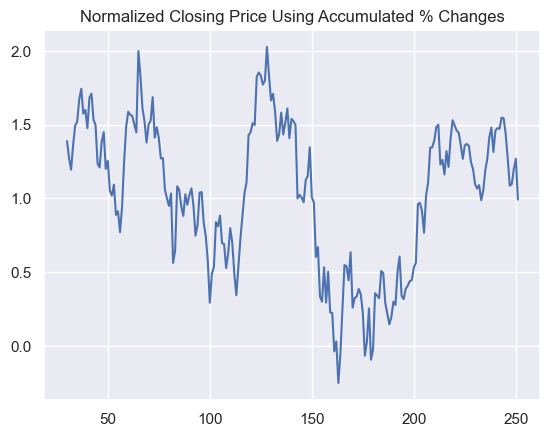

In [9]:
plt.plot(features['close'])
plt.title('Normalized Closing Price Using Accumulated % Changes')

### Load Sentiment Dataset and Select Ticker

In [ ]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification
from scipy.special import softmax

sentiment_df = pd.read_csv("../stock_tweets.csv")
sentiment_filt = sentiment_df['Stock Name'] == ticker
sentiment_df = sentiment_df[sentiment_filt]
sentiment_df['Date'] = pd.to_datetime(sentiment_df['Date'], utc=True).dt.date
sentiment_df.pop('Stock Name')
sentiment_df.pop('Company Name')
sentiment_df.sort_values(by='Date', inplace=True)
sentiment_df.head()

,Date,Tweet
37421,2021-09-30,"In other words, AMD has been giving Tesla pref..."
37355,2021-09-30,Screw these manipulative MM bitches. I'm in fo...
37356,2021-09-30,I forgot today was the last day of the qtr. Ty...
37357,2021-09-30,Look at this footage of @Tesla #FSD #Autopilot...
37358,2021-09-30,Has anyone ever published a credible explanati...


### Define Finbert Stock Sentiment Model

In [45]:
def load_finbert_model():
    model_name = "ProsusAI/finbert"
    tokenizer = BertTokenizer.from_pretrained(model_name)
    model = BertForSequenceClassification.from_pretrained(model_name)
    return tokenizer, model

def classify_sentiment(tweet, tokenizer, model):
    inputs = tokenizer(tweet, return_tensors="pt", truncation=True, padding=True, max_length=512)
    with torch.no_grad():
        outputs = model(**inputs)
    scores = softmax(outputs.logits.numpy())[0]
    sfeature = scores[0] - scores[1]
    return sfeature

### Generate Useful Sentiment Features

In [58]:
tokenizer, model = load_finbert_model()
sentiment_df['sent_score'] = sentiment_df['Tweet'].apply(lambda t: classify_sentiment(t, tokenizer, model))
sentiment_df.head()

,Date,Tweet,sent_score
37421,2021-09-30,"In other words, AMD has been giving Tesla pref...",0.018228
37355,2021-09-30,Screw these manipulative MM bitches. I'm in fo...,-0.043717
37356,2021-09-30,I forgot today was the last day of the qtr. Ty...,-0.126599
37357,2021-09-30,Look at this footage of @Tesla #FSD #Autopilot...,-0.053911
37358,2021-09-30,Has anyone ever published a credible explanati...,-0.008615


In [164]:
agg_sent = sentiment_df.copy()
agg_sent.pop('Tweet')
agg_sent['Date'] = agg_sent['Date'].astype(str)
valid_days = set(df['date'])

last_wd = agg_sent.at[0, 'Date']
for i in range(1, len(agg_sent)):
    if agg_sent.at[i, 'Date'] in valid_days:
        last_wd = agg_sent.at[i, 'Date']
    else:
        agg_sent.at[i, 'Date'] = last_wd
agg_sent = agg_sent.groupby(['Date'], as_index=False).mean()
agg_sent.head()

,Date,sent_score
0,2021-09-30,-0.021308
1,2021-10-01,0.026868
2,2021-10-04,0.089134
3,2021-10-05,0.052018
4,2021-10-06,0.021548


### Concatenate Numerical and Sentiment Features

In [174]:
window_agg_sent = agg_sent[window:].copy()
if len(features)==len(window_agg_sent):
    features['Sentiment'] = window_agg_sent['sent_score']
else:
    print('length mismatch')
features.to_csv('gru_features.csv', index=False)
features.head()

,target,close,volume,day_HL,sma,ema,rsi,macd_line,macd_signal,macd_histogram,bb_middle,bb_upper,bb_lower,Sentiment
30,-0.415753,1.389737,-0.225144,1.205485,1.225250,1.240823,1.294347,0.337084,0.377391,-0.040307,1.225250,2.329673,0.120826,0.028532
31,-2.829310,1.274551,-0.123877,0.834094,1.271798,1.244036,1.048356,0.298930,0.361699,-0.062768,1.271798,2.295270,0.248325,0.016304
32,-1.938224,1.195642,0.185585,1.239311,1.307861,1.239427,1.022191,0.259337,0.341226,-0.081890,1.307861,2.261470,0.354252,-0.034461
33,4.079377,1.361721,-0.103368,1.246601,1.353595,1.251074,1.061015,0.238609,0.320703,-0.082094,1.353595,2.216830,0.490360,0.003596
34,3.250121,1.494039,0.042524,1.399640,1.405584,1.274213,1.051915,0.230206,0.302603,-0.072398,1.405584,2.159023,0.652145,0.055099


### Generate GRU train and test split

In [4]:
features = pd.read_csv("gru_features.csv") # if loading pregenerated features
target = 0 #predict closing delta
data = features.to_numpy()
datax, datay = generate_LSTM_data(data, sequence_size=20, target_idx=target, pred_size=2)
print('LSTM Data')
print("> Data X: " + str(datax.shape))
print("> Data y: " + str(datay.shape))
test_size = 30
datax_train = datax[:-test_size]
datay_train = datay[:-test_size]
print('Train Set')
print("> Data X: " + str(datax_train.shape))
print("> Data y: " + str(datay_train.shape))
datax_test = datax[-test_size:]
datay_test = datay[-test_size:]
print('Test Set')
print("> Data X: " + str(datax_test.shape))
print("> Data y: " + str(datay_test.shape))

LSTM Data
> Data X: (200, 20, 14)
> Data y: (200, 2)
Train Set
> Data X: (170, 20, 14)
> Data y: (170, 2)
Test Set
> Data X: (30, 20, 14)
> Data y: (30, 2)


### Define GRU Model

In [5]:
class GRU_Model(tf.keras.Model):
    def __init__(self, num_layers, hidden_dim, output_size, dropout_rate=0.1):
        super(GRU_Model, self).__init__()
        
        self.num_layers = num_layers
        self.hidden_dim = hidden_dim
        self.output_size = output_size

        self.gru_layers = [
            tf.keras.layers.GRU(
                hidden_dim,
                activation='tanh',
                return_sequences=True
            ) for _ in range(num_layers-1)
        ]
        self.last_gru = tf.keras.layers.GRU(
            hidden_dim,
            activation='tanh',
            return_sequences=False
        )
        self.dropout = tf.keras.layers.Dropout(dropout_rate)
        self.dense1 = tf.keras.layers.Dense(hidden_dim//2)
        self.dense2 = tf.keras.layers.Dense(output_size)
    
    def call(self, x):
        for gru_layer in self.gru_layers:
            x = gru_layer(x)
            x = self.dropout(x)
        x = self.last_gru(x)
        x = self.dropout(x)
        x = self.dense1(x)
        x = self.dropout(x)
        x = self.dense2(x)
        return x

### Train Model

In [6]:
mymodel = GRU_Model(num_layers=5, hidden_dim=128, output_size=2, dropout_rate=0.1)
mymodel.compile(optimizer="adam", loss="mean_squared_error")
eval = mymodel.evaluate(datax_train, datay_train)

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 18.8910  


In [7]:
history = mymodel.fit(
    x = datax_train,
    y = datay_train,
    validation_split=0.25,
    epochs=20,
    batch_size=128
)

Epoch 1/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 19.8427 - val_loss: 15.9819
Epoch 2/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - loss: 20.0910 - val_loss: 15.2310
Epoch 3/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - loss: 19.7604 - val_loss: 14.9130
Epoch 4/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - loss: 19.8223 - val_loss: 14.8667
Epoch 5/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - loss: 19.8175 - val_loss: 14.9333
Epoch 6/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - loss: 19.7481 - val_loss: 15.0598
Epoch 7/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - loss: 19.6865 - val_loss: 15.2019
Epoch 8/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - loss: 19.6620 - val_loss: 15.2237
Epoch 9/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - loss: 19.6259 - val_loss: 15.0941
Epoch 10/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - loss: 19.5492 - val_loss: 14.9235
Epoch 11/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - loss: 19.4640 - val_loss: 14.8149
Epoch 12/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - loss: 19.3641

### Plot Performance

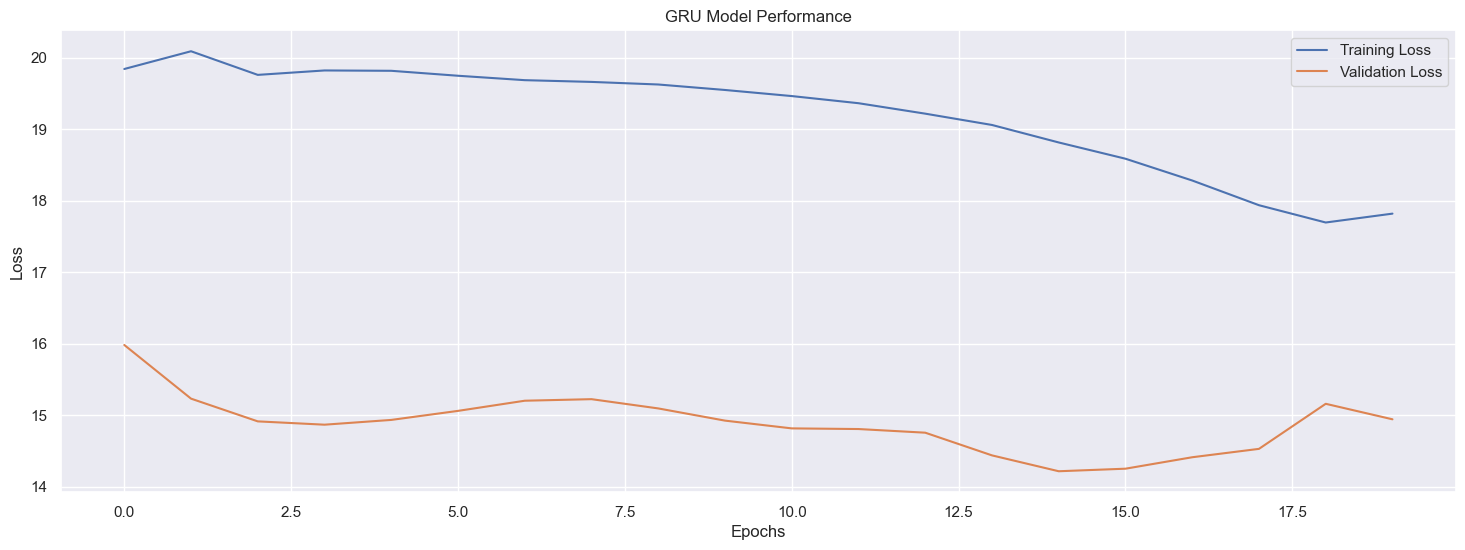

In [8]:
# Visualizing model performance during training
plt.figure(figsize=(18, 6))

plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")

plt.title("GRU Model Performance")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

### 1 Day Advance Prediction

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


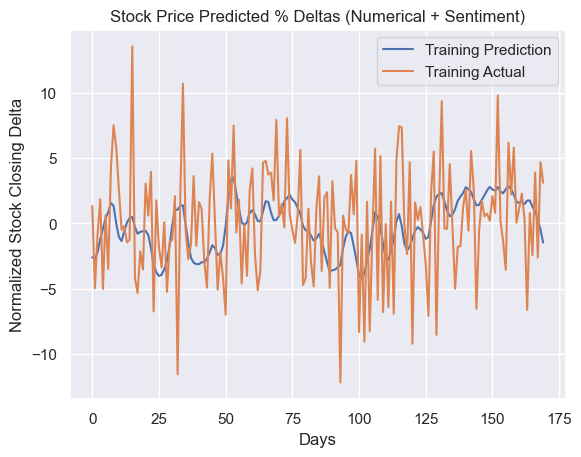

In [9]:
train_predictions = mymodel.predict(datax_train)
train_actual = datay_train
plt.plot(train_predictions[:, 0], label='Training Prediction')
plt.plot(train_actual[:, 0], label='Training Actual')
plt.title('Stock Price Predicted % Deltas (Numerical + Sentiment)')
plt.xlabel('Days')
plt.ylabel('Normalized Stock Closing Delta')
plt.legend()

In [10]:
diff = np.sign(train_predictions[:, 0].flatten())-np.sign(train_actual[:, 0].flatten())
thresh = np.max(np.abs(train_predictions[:, 0]))/2
thresh = 2
significant = np.where(np.abs(train_predictions[:, 0].flatten()) > thresh)
print('We perform predictions for ' + str(len(diff)) + ' days')
print('Let a significant day be a day where the absolute value of the predicted closing percent delta is greater than ' + str(thresh))
print('There are ' + str(len(significant[0])) + ' such events')
print('Of those events, we predict ' + str(np.count_nonzero(diff[significant])) + ' incorrectly')
num_wrong = np.count_nonzero(diff)
err = num_wrong/len(diff)
print('Overall Error Rate: ' + str(err*100) + '%')

We perform predictions for 170 days
Let a significant day be a day where the absolute value of the predicted closing percent delta is greater than 2
There are 59 such events
Of those events, we predict 19 incorrectly
Overall Error Rate: 37.64705882352941%


### 2 Day Advance Prediction

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


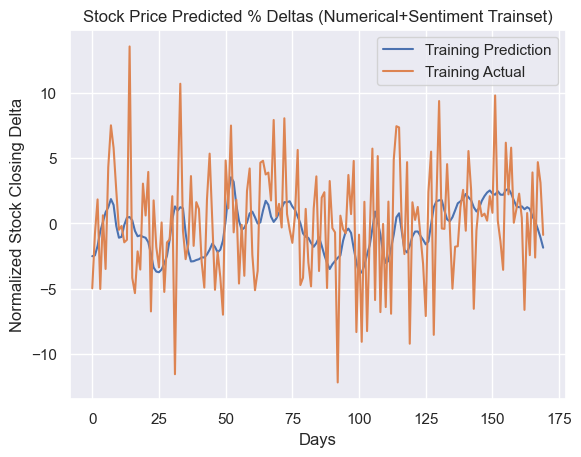

In [16]:
train_predictions = mymodel.predict(datax_train)
train_actual = datay_train
plt.plot(train_predictions[:, 1], label='Training Prediction')
plt.plot(train_actual[:, 1], label='Training Actual')
plt.title('Stock Price Predicted % Deltas (Numerical+Sentiment Trainset)')
plt.xlabel('Days')
plt.ylabel('Normalized Stock Closing Delta')
plt.legend()

In [12]:
diff = np.sign(train_predictions[:, 1].flatten())-np.sign(train_actual[:, 1].flatten())
thresh = np.max(np.abs(train_predictions[:, 1]))/2
thresh = 2
significant = np.where(np.abs(train_predictions[:, 1].flatten()) > thresh)
print('We perform predictions for ' + str(len(diff)) + ' days')
print('Let a significant day be a day where the absolute value of the predicted closing percent delta is greater than ' + str(thresh))
print('There are ' + str(len(significant[0])) + ' such events')
print('Of those events, we predict ' + str(np.count_nonzero(diff[significant])) + ' incorrectly')
num_wrong = np.count_nonzero(diff)
err = num_wrong/len(diff)
print('Overall Error Rate: ' + str(err*100) + '%')

We perform predictions for 170 days
Let a significant day be a day where the absolute value of the predicted closing percent delta is greater than 2
There are 52 such events
Of those events, we predict 17 incorrectly
Overall Error Rate: 37.64705882352941%


The accumulated % deltas clearly perform noticably better than 1-day predictions


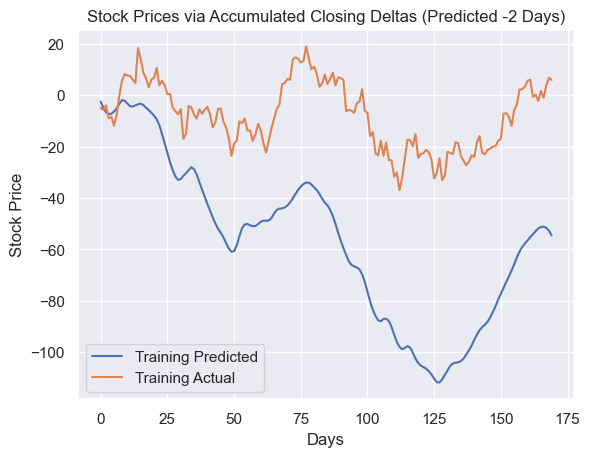

In [13]:
stock_price_train_pred = np.cumsum(train_predictions[:, 1])
stock_price_train_actual = np.cumsum(train_actual[:, 1])
plt.plot(stock_price_train_pred, label='Training Predicted')
plt.plot(stock_price_train_actual, label='Training Actual')
plt.title('Stock Prices via Accumulated Closing Deltas (Predicted -2 Days)')
plt.xlabel('Days')
plt.ylabel('Stock Price')
plt.legend()
print('The accumulated % deltas clearly perform noticably better than 1-day predictions')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


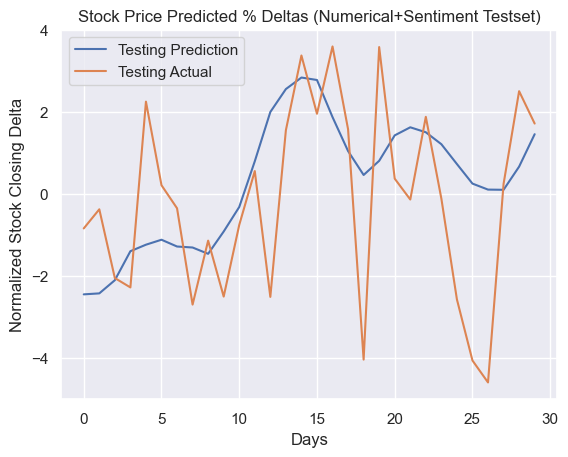

In [18]:
test_predictions = mymodel.predict(datax_test)
test_actual = datay_test
plt.plot(test_predictions[:, 1], label='Testing Prediction')
plt.plot(test_actual[:, 1], label='Testing Actual')
plt.title('Stock Price Predicted % Deltas (Numerical+Sentiment Testset)')
plt.xlabel('Days')
plt.ylabel('Normalized Stock Closing Delta')
plt.legend()